In [1]:
from drugSite_scrapers3 import drug, review as drug, review

In [2]:
import sys, pickle, re
from time import time
from collections import Counter, OrderedDict

import pandas as pd 
# from itertools import islice
import itertools

import numpy as np
import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline

In [3]:
from numpy.random import uniform, seed
from matplotlib.mlab import griddata
from numpy import linspace, meshgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy.random import uniform, seed

In [4]:
from sklearn import cluster, datasets, metrics
from sklearn.metrics import euclidean_distances, confusion_matrix

from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.cluster import KMeans, MiniBatchKMeans

from textblob import TextBlob

In [5]:
class drug_dataset:
    
    def __init__(self, _one_drug_df):
        self.data, self.target = self.filter_set_data(_one_drug_df)
        self.target_names = self.set_target_names()

    def filter_set_data(self, _one_drug_df):
        abbrev = 'ddc'
        if abbrev == 'ddc':
            rating = 'genRating'
        elif _one_drug.site == 'wmd':
            rating = 'satisfaction'
            
        df_temp = _one_drug_df[['comment', rating]].dropna(thresh=2)
        data = df_temp['comment'].tolist()
        targets = df_temp[rating].tolist()

        return data, targets     

    def set_target_names(self):
        return list(set(self.target))

In [6]:
def merge_generics(lst):
    c = Counter
    generics = {}
    listed = []
    for drug in lst:
        if drug.generic in generics:
            generics[drug.generic].append(drug)
        else:
            generics[drug.generic] = [drug] 

    merg = []
    merged_datasets = []
    for drug in generics:
        all_together = generics[drug][0]
        for ik in range(1,len(generics[drug])):
            all_together.reviews = all_together.reviews +generics[drug][ik].reviews
        merg.append(all_together)

    for drug in merg:
        drug.build_df()
        merged_datasets.append(drug_dataset(drug.df))
        print(drug.generic, len(drug.df), len(drug_dataset(drug.df).data))
        
    return merg, merged_datasets

In [7]:
def merge_all_drugs(lst):
    merged, merged_datasets = merge_generics(lst)
    _all_together = merged[0]
    for generic_drug in merged[1:]:
        _all_together.reviews = _all_together.reviews +generic_drug.reviews

    _all_together.build_df()   
    _all_together_dataset = drug_dataset(_all_together.df)
    print('all drugs', len(_all_together.df), len(_all_together_dataset.data))
    return _all_together, _all_together_dataset

#### Load one drug dataset

In [208]:
# One drug dataset from one drug list
mini_drug_list = pickle.load(open('drug_list_ddc_mini.p', 'rb'))
one_drug = mini_drug_list[0]
one_drug.build_df()
dataset = drug_dataset(one_drug.df)

#### Merge generics

In [9]:
small_drug_list = pickle.load(open('drug_list_ddc_pg1.p', 'rb'))

In [10]:
merged_drugs, merged_datasets = merge_generics(small_drug_list)

duloxetine systemic 950 897
sertraline systemic 1225 1151
escitalopram systemic 1050 985
fluoxetine systemic 750 702
citalopram systemic 825 775
bupropion systemic 1300 1207
aripiprazole systemic 250 237
venlafaxine systemic 1000 947
desvenlafaxine systemic 600 557
mirtazapine systemic 325 302
vilazodone systemic 525 485


In [11]:
ind = 5
one_drug = merged_drugs[ind]
dataset = merged_datasets[ind]

#### All drug dataset

In [218]:
all_drugs, all_drugs_dataset = merge_all_drugs(small_drug_list)
one_drug = all_drugs
dataset = all_drugs_dataset

duloxetine systemic 19800 18547
sertraline systemic 4325 4067
escitalopram systemic 3450 3225
fluoxetine systemic 2550 2386
citalopram systemic 2925 2743
bupropion systemic 2700 2499
aripiprazole systemic 250 237
venlafaxine systemic 2200 2071
desvenlafaxine systemic 600 557
mirtazapine systemic 325 302
vilazodone systemic 525 485
all drugs 39650 37119


##### Info:

In [19]:
print(one_drug.attributes)
print(one_drug.__dict__.keys())

['drugName', 'site', 'condition', 'reviewDate', 'userName', 'ageRange_str', 'gender', 'role', 'medDuration_str', 'effectiveness', 'ease_of_use', 'satisfaction', 'genRating', 'upVotes']


### Split off subsets

In [17]:
one_drug.attributeDetails['medDuration_str']

{'[6, 12]', '[120, 300]', '[60, 120]', '[1, 6]', '[0, 1]', '[24, 60]', None}

In [138]:
attr = 'medDuration_str'

medDur_d = {}
for subset in one_drug.attributeDetails[attr]:
    medDur_d[str(subset)] = one_drug.slice_data(attr, subset)
    print(str(subset), len(medDur_d[str(subset)]))
    
frames = [medDur_d['[0, 1]'], medDur_d['[1, 6]'], medDur_d['[6, 12]']]

leq_1year = pd.concat(frames)
leq_1year.describe()

[24, 60] 1152
[60, 120] 643
[120, 300] 461
[1, 6] 4190
[0, 1] 3571
None 0
[6, 12] 1433


In [162]:
# make dataset from a particular slice
dataset = drug_dataset(leq_1year)

In [17]:
len(one_drug.df), len(dataset.data)

(450, 426)

### Whether to leave with 10 labels, or bin them to 5 or 6

#### Not re-binned labels

In [12]:
labels = dataset.target
target_names = dataset.target_names

#### 6 bins: 

In [11]:
bins_l= ['1', '2-3', '4-5', '6-7', '8-9', '10']
bin_conversion = OrderedDict({1:'1', 2:'2-3', 3:'2-3', 4:'4-5', 5:'4-5', 6:'6-7', 7:'6-7', 8:'8-9', 9: '8-9', 10:'10'})

#### 5 bins (model 1): 

In [32]:
bins_l= ['1-2', '3-4', '5-6', '7-8', '9-10']
bin_conversion = OrderedDict({1:'1-2', 2:'1-2', 3:'3-4', 4:'3-4',5:'5-6', 6:'5-6', 7:'7-8', 8:'7-8', 9:'9-10', 10:'9-10'})

#### 5 bins (model 2): 

In [52]:
bins_l= ['1', '2-4', '5-6', '7-9', '10']
bin_conversion = OrderedDict({1:'1', 2:'2-4', 3:'2-4', 4:'2-4', 5:'5-6', 6:'5-6', 7:'7-9', 8:'7-9', 9: '7-9', 10:'10'})

In [53]:
bins_l = []
for _bin in bin_conversion:
    if bin_conversion[_bin] not in bins_l:
        bins_l.append(bin_conversion[_bin])

# bins_l = list(set(bins_ls))
bins_d = OrderedDict()
for ik, _bin in enumerate(bins_l):
    bins_d[_bin] = ik+1
    
print(bins_l)
print(bins_d)

binned_targets = []
for target in dataset.target:
    binned_targets.append(bins_d[bin_conversion[target]])
#     print(target, ',', bin_conversion[target], ',', bins_d[bin_conversion[target]])
    
labels = binned_targets
target_names = bins_l

['1', '2-4', '5-6', '7-9', '10']
OrderedDict([('1', 1), ('2-4', 2), ('5-6', 3), ('7-9', 4), ('10', 5)])


## Extracting features from the training dataset using a sparse vectorizer

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

count_vect = CountVectorizer(lowercase=True, ngram_range=(0,1))
transformer = TfidfTransformer()

X = count_vect.fit_transform(dataset.data)
X_tfidf = transformer.fit_transform(X)


/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, labels, test_size=0.2, random_state=0)

## Land of Classifying

In [18]:
from sklearn.cross_validation import cross_val_score, KFold

In [23]:
# Next, some classifiers. 
# Start with logistic regression. 
# print a full classification report after you have trained the classifier and made predictions. 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [24]:
classifiers = {'Decision Tree': DecisionTreeClassifier(),'mlp classifier': MLPClassifier(), "log reg": LogisticRegression(), 'multinomial NB': MultinomialNB(), 'DTree': DecisionTreeClassifier()}

In [54]:
def plot_confusion_matrix(fig, ax, cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    im1 = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
#     fig.colorbar(im1, ax=ax)
#     fig.colorbar()
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks, classes)#, rotation=45)
    ax.set_yticks(tick_marks, classes)
    
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
#     fig.colorbar(im1, cax=cax)
    plt.colorbar(im1,fraction=0.046, pad=0.04)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

#     ax.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

[ 0.49  0.39  0.49  0.45  0.44]
Confusion matrix, without normalization
[[11  0  2  0  0  0  3  3  0  1]
 [ 0  8  0  0  0  0  2  1  2  2]
 [ 0  0  2  0  0  0  0  0  0  1]
 [ 0  0  0  6  0  1  1  1  1  0]
 [ 1  0  1  1  5  0  1  2  0  3]
 [ 2  2  0  0  1  4  0  3  1  1]
 [ 1  0  0  0  0  0 12  1  1  1]
 [ 1  0  0  0  2  2  1 18  3  7]
 [ 0  2  2  1  1  0  0  6 31 11]
 [ 6  2  0  2  2  0  2  6  7 35]]
Normalized confusion matrix
[[ 0.55  0.    0.1   0.    0.    0.    0.15  0.15  0.    0.05]
 [ 0.    0.53  0.    0.    0.    0.    0.13  0.07  0.13  0.13]
 [ 0.    0.    0.67  0.    0.    0.    0.    0.    0.    0.33]
 [ 0.    0.    0.    0.6   0.    0.1   0.1   0.1   0.1   0.  ]
 [ 0.07  0.    0.07  0.07  0.36  0.    0.07  0.14  0.    0.21]
 [ 0.14  0.14  0.    0.    0.07  0.29  0.    0.21  0.07  0.07]
 [ 0.06  0.    0.    0.    0.    0.    0.75  0.06  0.06  0.06]
 [ 0.03  0.    0.    0.    0.06  0.06  0.03  0.53  0.09  0.21]
 [ 0.    0.04  0.04  0.02  0.02  0.    0.    0.11  0.57  0.2 ]
 [

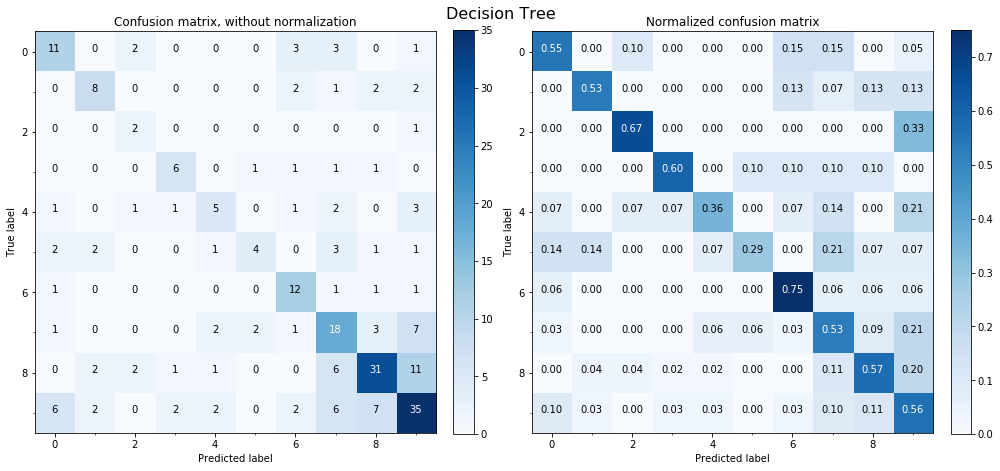

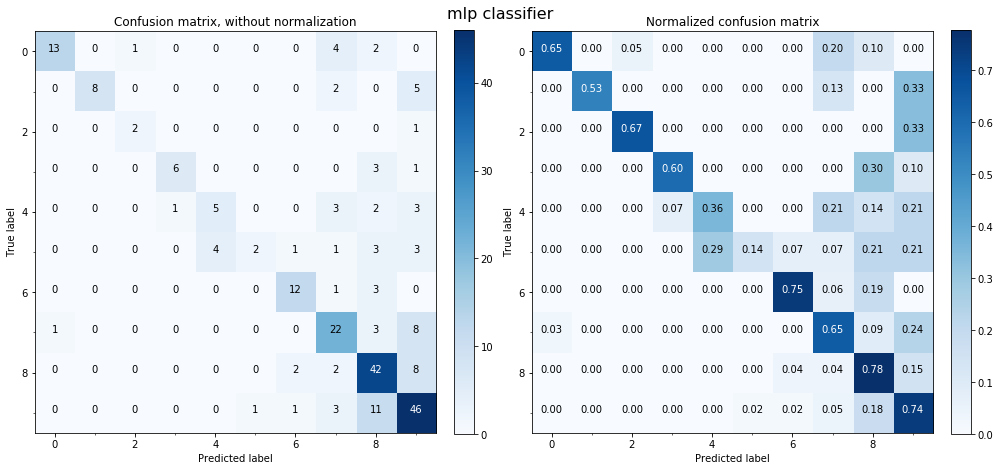

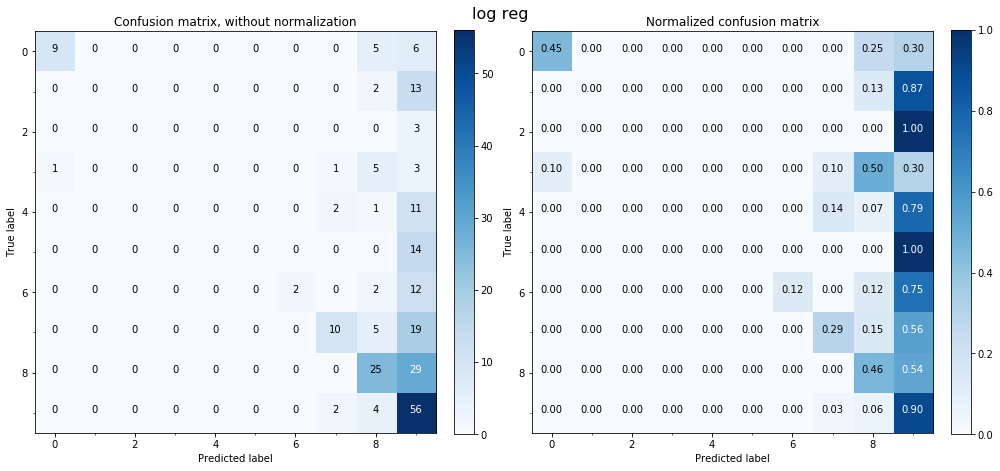

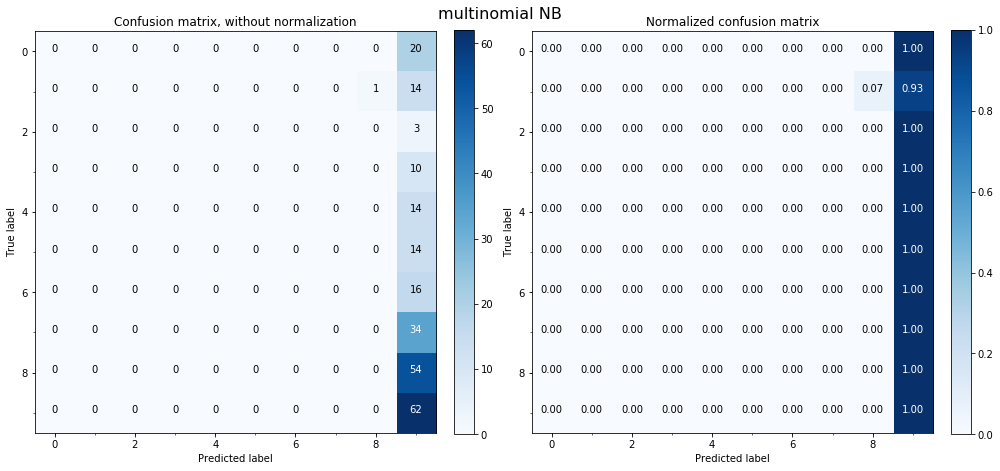

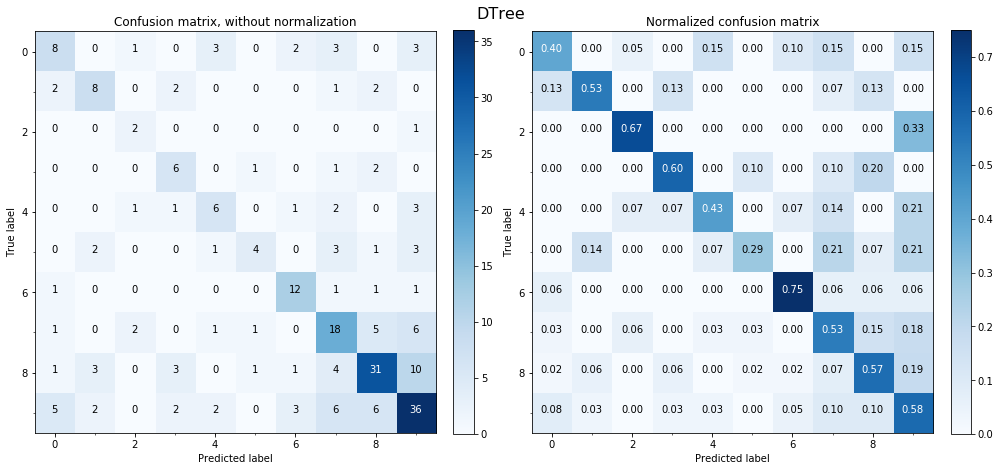

In [56]:
import matplotlib.cm as cm
from matplotlib import gridspec

for key in classifiers:
    classifier = classifiers[key]
    print(cross_val_score(classifier,X_train_tfidf, y_train, cv = 5, scoring='accuracy'))
    y_pred = classifier.fit(X_train_tfidf, y_train).predict(X_test_tfidf)

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
#     plt.figure()
    figSize = (14, 7)
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figSize, facecolor='w')
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    st = fig.suptitle(key, fontsize=16)
    st.set_y(0.95)
    
    ax1 = plt.subplot(gs[0])
    plot_confusion_matrix(fig, ax1, cnf_matrix, classes=target_names,
                          title='Confusion matrix, without normalization')
#     print(key)
    # Plot normalized confusion matrix
#     plt.figure()
    ax2 = plt.subplot(gs[1])
    plot_confusion_matrix(fig, ax2, cnf_matrix, classes=target_names, normalize=True,
                          title='Normalized confusion matrix')
    fig.tight_layout()


Confusion matrix, without normalization
[[13  1  1  0  0  0  1  3  1  0]
 [ 4  8  0  0  0  0  0  1  0  2]
 [ 0  0  2  0  0  0  0  0  1  0]
 [ 1  0  0  6  0  0  0  2  0  1]
 [ 0  1  0  0  5  0  0  0  0  8]
 [ 1  0  0  0  0  2  0  1  5  5]
 [ 0  0  0  0  0  0 12  1  2  1]
 [ 1  0  0  0  0  0  0 20  6  7]
 [ 2  0  1  0  0  0  2  2 34 13]
 [ 1  0  0  0  0  0  0  9  5 47]]
Normalized confusion matrix
[[ 0.65  0.05  0.05  0.    0.    0.    0.05  0.15  0.05  0.  ]
 [ 0.27  0.53  0.    0.    0.    0.    0.    0.07  0.    0.13]
 [ 0.    0.    0.67  0.    0.    0.    0.    0.    0.33  0.  ]
 [ 0.1   0.    0.    0.6   0.    0.    0.    0.2   0.    0.1 ]
 [ 0.    0.07  0.    0.    0.36  0.    0.    0.    0.    0.57]
 [ 0.07  0.    0.    0.    0.    0.14  0.    0.07  0.36  0.36]
 [ 0.    0.    0.    0.    0.    0.    0.75  0.06  0.12  0.06]
 [ 0.03  0.    0.    0.    0.    0.    0.    0.59  0.18  0.21]
 [ 0.04  0.    0.02  0.    0.    0.    0.04  0.04  0.63  0.24]
 [ 0.02  0.    0.    0.    0.    0

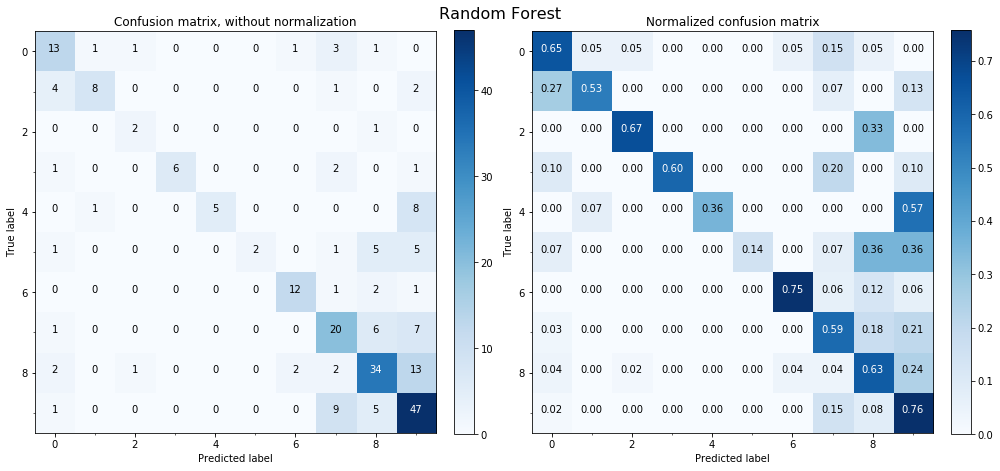

In [58]:
# Now let's try to do the random forest 
from sklearn.ensemble import RandomForestClassifier

X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()
classifier = RandomForestClassifier(n_estimators = 10)
cross_val_score(classifier,X_train_tfidf_dense, y_train, cv=5, scoring='accuracy')

y_pred = classifier.fit(X_train_tfidf, y_train).predict(X_test_tfidf)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

figSize = (14, 7)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figSize, facecolor='w')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
st = fig.suptitle("Random Forest", fontsize=16)
st.set_y(0.95)

ax1 = plt.subplot(gs[0])
plot_confusion_matrix(fig, ax1, cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')
#     print(key)
# Plot normalized confusion matrix
#     plt.figure()
ax2 = plt.subplot(gs[1])
plot_confusion_matrix(fig, ax2, cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')
fig.tight_layout()



### Suppose we do sentiment analysis first...

In [30]:
# import nltk
 
# def format_sentence(sent):
#     return({word: True for word in nltk.word_tokenize(sent)})

In [35]:
# pos = []
# with open("pos_tweets.txt", 'r', encoding='utf-8') as f:
#     for i in f: 
#         pos.append([format_sentence(i), 'pos'])

# neg = []
# with open("neg_tweets.txt" , 'r', encoding='utf-8') as f:
#     for i in f: 
#         neg.append([format_sentence(i), 'neg'])

In [36]:
# training = pos[:int((.8)*len(pos))] + neg[:int((.8)*len(neg))]
# test = pos[int((.8)*len(pos)):] + neg[int((.8)*len(neg)):]

In [40]:
# from nltk.classify import NaiveBayesClassifier
 
# classifier = NaiveBayesClassifier.train(training)


In [44]:
# example1 = "Cats are awesome!"
 
# dist = classifier.prob_classify(format_sentence(example1))

'pos'

In [45]:
# dist.samples()

dict_keys(['pos', 'neg'])

In [38]:

# classifier.show_most_informative_features()
# classifier.show_most_informative_features()


Most Informative Features
                      no = True              neg : pos    =     19.4 : 1.0
                    love = True              pos : neg    =     19.0 : 1.0
                 awesome = True              pos : neg    =     17.2 : 1.0
                headache = True              neg : pos    =     16.2 : 1.0
                      Hi = True              pos : neg    =     12.7 : 1.0
               beautiful = True              pos : neg    =      9.7 : 1.0
                     New = True              pos : neg    =      9.7 : 1.0
                     fan = True              pos : neg    =      9.7 : 1.0
                   Thank = True              pos : neg    =      9.7 : 1.0
                    haha = True              pos : neg    =      9.3 : 1.0
Most Informative Features
                      no = True              neg : pos    =     19.4 : 1.0
                    love = True              pos : neg    =     19.0 : 1.0
                 awesome = True              pos

In [39]:
# from nltk.classify.util import accuracy
# print(accuracy(classifier, test))

0.8308457711442786


### Prep for clustering?

In [18]:
print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()
vectorizer = TfidfVectorizer(max_df=0.5, max_features=3000,  ngram_range=(1, 2),
                                 min_df=2, stop_words='english')

Extracting features from the training dataset using a sparse vectorizer


In [19]:
X = vectorizer.fit_transform(dataset.data)

In [20]:
print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

done in 1.645495s
n_samples: 1151, n_features: 3000



In [21]:
n_components = 100

In [22]:
if n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()

Performing dimensionality reduction using LSA
done in 0.164304s
Explained variance of the SVD step: 35%



## Land of Clustering

In [253]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from matplotlib import gridspec

In [242]:
print("%d documents" % len(dataset.data))
print("%d categories" % len(target_names))
print()

true_k = list(set(labels))
print(type(true_k[-1]))
true_k = np.unique(labels).shape[0]

4796 documents
5 categories

<class 'int'>


In [243]:
Counter(dataset.target)

Counter({1.0: 499,
         2.0: 220,
         3.0: 166,
         4.0: 138,
         5.0: 197,
         6.0: 222,
         7.0: 398,
         8.0: 700,
         9.0: 981,
         10.0: 1275})

In [244]:
Counter(labels)

Counter({1: 499, 2: 524, 3: 419, 4: 2079, 5: 1275})

In [167]:
# # new cell
# count_vect = CountVectorizer(stop_words='english', min_df = 2, lowercase=True, ngram_range=(1,2))
# X_train_counts = count_vect.fit_transform(dataset.data)

In [245]:
km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000)#, verbose=opts.verbose)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))


print()

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=5,
        n_init=1, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 0.100s

Homogeneity: 0.015
Completeness: 0.013
V-measure: 0.014
Adjusted Rand-Index: 0.006
Silhouette Coefficient: 0.014



In [246]:
if hasattr(km, 'labels_'):
                y_pred = km.labels_.astype(np.int)
else:
                y_pred = km.predict(X)

y_true = labels

In [247]:
def non_picks(pick_id):
    ids = [ik for ik in range(10)]
    ids.remove(pick_id)
    return ids

In [248]:
y_pred = [pred+1 for pred in y_pred]
print(set(y_pred))

{1, 2, 3, 4, 5}


In [249]:
# x, y, feat_data, basemap, xLab, yLab, latLon_params = amassData(df3_sub, in_var_names, sliceType, depth = Depth)
N_CLUSTERS = len(target_names)

# preds_dict, cluster_fig_SPO = test_clustering2( x, y, feat_data, xLab, yLab, N_CLUSTERS, latLon_params, Map = basemap)

In [250]:
def filter_count_scores(pick, _y_pred, _y_true):
    filtered_pred = []
    filtered_true = []
    for ik, score in enumerate(_y_pred):
        if score == pick:
            filtered_pred.append(_y_pred[ik])
            filtered_true.append(_y_true[ik])
            
    c = Counter(filtered_true)
    counts_ls = []
    for ik in np.arange(1,N_CLUSTERS+1):
        if ik in c.keys():
            counts_ls.append(c[ik])
        else:
            counts_ls.append(0)
    return counts_ls

In [251]:
def get_counts(preds):
    c = Counter(preds)
    counts_ls = []
    for ik in range(10):
        counts_ls.append(c[ik])
    return counts_ls


1
[ 0.8  1.8  2.8  3.8  4.8]
[189, 143, 67, 500, 386]
2
[ 0.88  1.88  2.88  3.88  4.88]
[115, 131, 66, 571, 348]
3
[ 0.96  1.96  2.96  3.96  4.96]
[97, 118, 143, 381, 163]
4
[ 1.04  2.04  3.04  4.04  5.04]
[52, 58, 70, 356, 248]
5
[ 1.12  2.12  3.12  4.12  5.12]
[46, 74, 73, 271, 130]


[None, None, None, None, None, None, None, None, None, None]

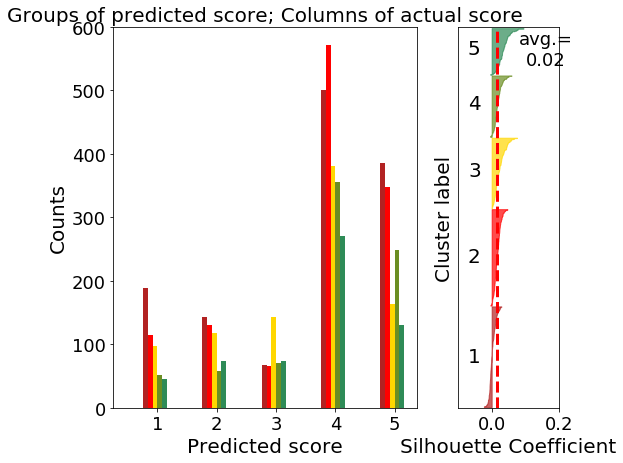

In [255]:
figSize = (1.6*N_CLUSTERS, 7)
title_sz = 27
axis_sz = 20
tick_sz = 18
colors = ['firebrick', 'red', 'gold', 'olivedrab', 'seagreen', 'lightseagreen', 'deepskyblue', 'slategray', 'navy', 'mediumpurple']


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figSize, facecolor='w')
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

score = metrics.silhouette_score(X, y_pred, metric='euclidean')

ax2 = plt.subplot(gs[1])
ax2.set_xlim([-0.1, .2])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
try:
    ax2.set_ylim([0, len(X) + (N_CLUSTERS + 1) * 10])
except:
    ax2.set_ylim([0, X.shape[0] + (N_CLUSTERS + 1) * 10])

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, y_pred)

y_lower = 10
y_pred = np.array(y_pred)

for i in range(1,1+N_CLUSTERS):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[y_pred == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = colors[i-1]#cm.spectral(float(i) / N_CLUSTERS)
    ax2.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax2.text(-0.07, y_lower + 0.45 * size_cluster_i, str(i), size=axis_sz)

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax2.text(.87, .90,'avg.=\n'+ '%.2f' % score, size=tick_sz, transform=plt.gca().transAxes,
    horizontalalignment='center')

#ax2.set_title("The silhouette plot for the various clusters.")
ax2.set_xlabel("Silhouette Coefficient", fontsize=axis_sz)
ax2.set_ylabel("Cluster label",fontsize=axis_sz)

# The vertical line for average silhoutte score of all the values
ax2.axvline(x=score, color="red", linestyle="--", linewidth=3)

ax2.set_yticks([])  # Clear the yaxis labels / ticks
#ax2.set_xticks([ 0, .3, .6, .9])

xtickNames = ax2.get_xticklabels()
ytickNames = ax2.get_yticklabels()

plt.setp(ytickNames, rotation=0, fontsize=tick_sz)
plt.setp(xtickNames, rotation=0, fontsize=tick_sz)


ax1 = plt.subplot(gs[0])
N = N_CLUSTERS
ind = np.arange(1,N+1)  # the x locations for the groups
width = 0.08       # the width of the bars
colors = ['firebrick', 'red', 'gold', 'olivedrab', 'seagreen', 'lightseagreen', 'deepskyblue', 'slategray', 'navy', 'mediumpurple']

for score in np.arange(1,N+1):
    cts = filter_count_scores(score, y_pred, y_true)
    rects = ax1.bar((ind-.5*N*width)+(score-1)*width, cts, width, color=colors[score-1])

plt.xticks([ik-.15*5 for ik in np.arange(1,N_CLUSTERS+1)],  np.arange(1,N_CLUSTERS+1), rotation='vertical')
plt.xticks([ik for ik in np.arange(1,N_CLUSTERS+1)], np.arange(1,N_CLUSTERS+1), rotation='vertical')

ax1.set_xlabel('Predicted score', fontsize=axis_sz)
ax1.set_ylabel('Counts', fontsize=axis_sz)

plt.title('Groups of predicted score; Columns of actual score', fontsize=axis_sz) 

xtickNames = ax1.get_xticklabels()
ytickNames = ax1.get_yticklabels()

plt.setp(ytickNames, rotation=0, fontsize=tick_sz)
plt.setp(xtickNames, rotation=0, fontsize=tick_sz)

In [254]:
blob_scores = []
for ik in range(len(dataset.data)):
    blob = TextBlob(dataset.data[ik])
    blob_scores.append(blob.polarity)
    
blob_scores = np.array(blob_scores)
hist, bin_edges = np.histogram(blob_scores, bins=9) #int(len(blob_scores)/10))
bin_inds = np.digitize(blob_scores,bin_edges,right=True) #[bn+1 for bn in np.digitize(blob_scores,bin_edges,right=True)]

from collections import Counter
c = Counter(bin_inds)
print(c)

for ik in range(len(c)):
    print(ik+1,'.) (', bin_edges[ik], bin_edges[ik],'):', hist[ik],' ; ', str(ik+1),': ', c[ik+1])
    

title_text = 'Predicted score relative to Polarity score'


Counter({5: 2338, 6: 1487, 4: 483, 7: 271, 3: 105, 8: 55, 9: 25, 2: 19, 0: 13})
1 .) ( -1.0 -1.0 ): 13  ;  1 :  0
2 .) ( -0.777777777778 -0.777777777778 ): 19  ;  2 :  19
3 .) ( -0.555555555556 -0.555555555556 ): 105  ;  3 :  105
4 .) ( -0.333333333333 -0.333333333333 ): 483  ;  4 :  483
5 .) ( -0.111111111111 -0.111111111111 ): 2338  ;  5 :  2338
6 .) ( 0.111111111111 0.111111111111 ): 1487  ;  6 :  1487
7 .) ( 0.333333333333 0.333333333333 ): 271  ;  7 :  271
8 .) ( 0.555555555556 0.555555555556 ): 55  ;  8 :  55
9 .) ( 0.777777777778 0.777777777778 ): 25  ;  9 :  25


In [81]:
ith_cluster_silhouette_values = sample_silhouette_values[np.array(y_pred) == 1]
ith_cluster_silhouette_values

array([-0.00475928,  0.01687339,  0.04554235,  0.02843631,  0.00801759,
        0.04196029,  0.01327778, -0.00085529,  0.02208712,  0.04523526,
        0.03174943,  0.04907269,  0.01032974,  0.03938316,  0.00119685,
        0.05088261,  0.02093159,  0.04881239,  0.03191275, -0.00360057,
        0.03760117,  0.05453996,  0.03240447,  0.04003465,  0.01921228,
        0.0832842 ,  0.04206405,  0.04027504,  0.00965791,  0.0378114 ,
       -0.00360057,  0.03240447,  0.04003465,  0.04027504, -0.00430439,
        0.03999815,  0.02318799,  0.10259215,  0.02849029,  0.00851325,
        0.00851325])

Text(0.5,1,'groups of predicted score, columns of actual score')

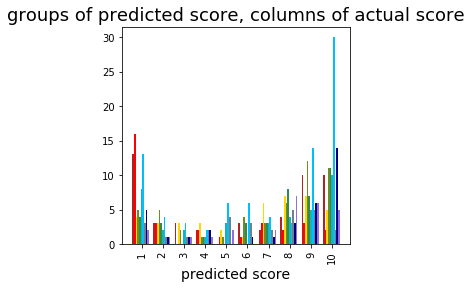

In [262]:

# fig, ax1 = plt.subplots(figsize = (22, 4), facecolor='w')

ax1 = plt.subplot(gs[0])
N = 10
ind = np.arange(1,11)  # the x locations for the groups
width = 0.08       # the width of the bars
colors = ['firebrick', 'red', 'gold', 'olivedrab', 'seagreen', 'lightseagreen', 'deepskyblue', 'slategray', 'navy', 'mediumpurple']

for score in np.arange(1,11):
    cts = filter_count_scores(score, y_pred, y_true)
    rects = ax1.bar((ind-5*width)+(score-1)*width, cts, width, color=colors[score-1])

plt.xticks([ik-.15*5 for ik in np.arange(1,11)],  np.arange(1,11), rotation='vertical')
plt.xticks([ik for ik in np.arange(1,11)], np.arange(1,11), rotation='vertical')

ax1.set_xlabel('predicted score', fontsize=14)
plt.title('groups of predicted score, columns of actual score', fontsize=18)      # ncol=4,  borderaxespad=0.,prop={'size':14-2})
